# Evaluate likelihood ratio

In [2]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from scipy.stats import norm
from sklearn.metrics import roc_curve

from inference.utils import s_from_r, shuffle
import paper_settings

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

In [3]:
paper_settings.setup()

## Setting

In [6]:
setting = "full"
filename = "alices_full_sgd1e2_grid"  # "calibrated_alices_full_sgd1e2_grid"
samples = [2, 16, 3,6,]

## Data

In [7]:
xs = np.load("../data/samples/x_test_{}_point.npy".format(setting))[samples]
llrs = np.load("../data/results/llr_{}.npy".format(filename))[:,samples]


In [8]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Plot

In [9]:
ncols = len(samples)
nrows = 2

gradmin, gradmax = -0.1, 0.1
gradrelmax = 0.002
xmin, xmax = 2.3, 3.15

llrmin, llrmax = 0., 25.
normalize_to_mle = True


/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


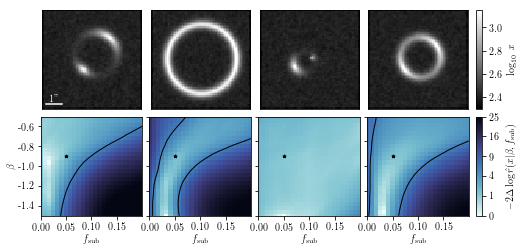

In [11]:
fig, gs = paper_settings.grid2_width(ncols, nrows)

for i in range(ncols):
    ax = plt.subplot(gs[i])
    im = plt.imshow(
        np.log10(xs[i]),
        vmin=xmin,
        vmax=xmax,
        cmap='gist_gray',
        extent=(-3.2,3.2,-3.2,3.2),
        origin="lower",
        alpha=1.
    )
    if i == 0:
        plt.plot([-2.9, -1.9], [-2.9, -2.9], c="white", lw=1.5, ls="-")
        plt.text(-2.4, -2.6, '$1$"', va="center", ha="center", color="white")
        
    plt.xlim(-3.2,3.2)
    plt.ylim(-3.2,3.2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    if i == 0:
        ax = plt.subplot(gs[ncols])
        cbar = plt.colorbar(im, cax=ax)
        cbar.set_label(r"$\log_{10} \; x$")
        cbar.set_ticks([2.4,2.6,2.8,3.0])
        ax.yaxis.set_label_coords(5.3, 0.5)
        
        
    
    ax = plt.subplot(gs[ncols + 1 + i])
    z = -2. * llrs[:, i]
    z = z - np.min(z)
    z_clip = np.clip(z, llrmin, llrmax)
    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        (z_clip**0.5).reshape((resolution, resolution)),
        norm=matplotlib.colors.Normalize(vmin=llrmin**0.5, vmax=llrmax**0.5),
        cmap=paper_settings.CMAP1
    )
    cs = plt.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        z.reshape((resolution, resolution)),
        [5.991464547107983],
        colors="black",
        linewidths=1.,
        linestyles=["-"]
    )
    plt.scatter(0.05, -1.9, s=10., color='black', marker='*')
    plt.xlim(0.,0.2)
    plt.ylim(-2.5,-1.5) 
    
    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.xticks([0.,0.05,0.1,0.15])
    if i == 0:
        plt.ylabel(r'$\beta$')
        plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
        ax.yaxis.set_label_coords(-0.24, 0.5)
    else:
        plt.ylabel(None)
        ax.set_yticklabels(['' for item in ax.get_xticklabels()])
    
    if i == 0:
        ax = plt.subplot(gs[2*ncols + 1])
        cbar = fig.colorbar(
            pcm,
            cax=ax,
            ticks=[0.,1.,2.,3.,4.,5.],
            format=matplotlib.ticker.FuncFormatter(lambda x, _ : "{:.0f}".format(x**2))
        )
        cbar.set_label(r'$-2 \Delta \log \hat{r}(x | \beta, f_{\mathrm{sub}})$')
        ax.yaxis.set_label_coords(5., 0.5)

    
plt.savefig("../figures/individual_lens_predictions.pdf")
    